In [1]:
%matplotlib inline

In [2]:
import argparse
import collections
import sqlite3
import sys

import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from importlib import reload
import parse_db
reload(parse_db)

<module 'parse_db' from '/Users/jobevers/projects/personal/bowlingscorer/parse_db.py'>

In [4]:
conn = sqlite3.connect('/Users/jobevers/Dropbox/bowling/Backup.db')
conn.row_factory = sqlite3.Row 

In [5]:
parse_db.process_db(conn)

First Ball Average: 8.548979591836735
You've bowled 490 frames
---
Pin Leaves
Pin	1	2
1	12.86%	2.45%
2	15.31%	3.47%
3	15.71%	4.49%
4	16.53%	4.90%
5	14.08%	2.86%
6	18.78%	5.71%
7	15.31%	6.33%
8	5.92%	1.84%
9	9.18%	1.84%
10	21.43%	9.39%
---
Strikes: 154 / 490 => 31.428571%
Spares: 183 / 490 => 37.346939%
Opens: 153 / 490 => 31.224490%
---
Splits: 65 / 336 => 19.345238%
Split-Conversion: 10 / 65 => 15.384615%
---
Non-Splits: 271 / 336 => 80.654762%
Non-Split-Conversion: 173 / 271 => 63.837638%
---
Single Pin Leaves: 127 / 271 => 0.46863468634686345
Single Pin Conversion: 85 / 127 =>  0.6692913385826772
For pin 10: 17 / 30 => 56.7%
For pin 7: 8 / 16 => 50.0%
For pin 6: 16 / 23 => 69.6%
For pin 3: 10 / 14 => 71.4%
For pin 2: 1 / 4 => 25.0%
For pin 9: 9 / 11 => 81.8%
For pin 8: 1 / 3 => 33.3%
For pin 4: 10 / 12 => 83.3%
For pin 5: 12 / 13 => 92.3%
For pin 1: 1 / 1 => 100.0%
SINGLE PIN CONVERSION IS THE EASIEST WAY TO IMPROVE YOUR AVERAGE!
IF THIS WAS 100%, YOUR AVERAGE WOULD INCREASE BY: 8.1

In [6]:
# ['ID', 'EventID', 'Game', 'Score']
rows = conn.execute('select * from T_Score').fetchall()
totals = pd.DataFrame(rows, columns=rows[0].keys())

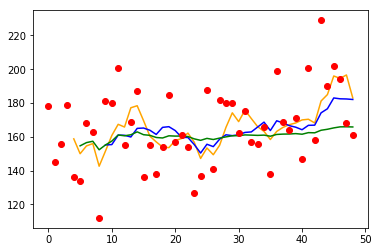

In [7]:
fig, ax = plt.subplots()
scores = totals['Score']
scores.rolling(5).mean().plot(ax=ax, label='5gm Avg', color="orange")
scores.rolling(10).mean().plot(ax=ax, label='10gm Avg', color="blue")
scores.expanding(6).mean().plot(ax=ax, label='League Avg', color="green")
scores.plot(ax=ax, marker='o', linestyle='', color="red");
#ax.legend()

In [8]:
# ['ID', 'Game', 'Frame', 'T1', 'T2', 'Foul1', 'Foul2', 'Split', 'Renzoku', 'Pin']
rows = conn.execute('select * from T_Games where Frame <= 10').fetchall()
frames_df = pd.DataFrame(rows, columns=rows[0].keys())
fba = frames_df['T1'].mean()
print(f'First Ball Average: {fba}')

pin_leaves = []
for row in rows:
    pins = row['Pin']
    pin_leaves.append(parse_db.parse_pins(pins))
n = len(pin_leaves)

First Ball Average: 8.548979591836735


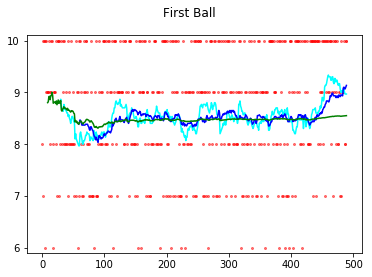

In [10]:
fig, ax = plt.subplots()
scores = frames_df['T1']
scores.plot(ax=ax, marker='o', linestyle='', markersize=2, color="red", alpha=.5);
scores.rolling(30).mean().plot(ax=ax, label='30fm Avg', color="cyan")
scores.rolling(60).mean().plot(ax=ax, label='60fm Avg', color="blue")
scores.expanding(10).mean().plot(ax=ax, label='League Avg', color="green")
fig.suptitle('First Ball')
ax.set_ylim(5.9, 10.1)
ax.set_yticks((6, 7, 8, 9, 10));

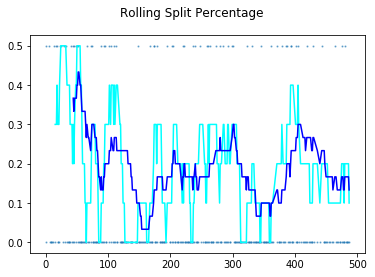

In [11]:
# Split percentage is fraction of NON-STRIKES that were splits.
is_not_strike = frames_df[frames_df['T1'] < 10]
is_split = (is_not_strike['Split'] == 1).astype(int)
is_split.rolling(10).mean().plot(color="cyan")
ax = is_split.rolling(30).mean().plot(color="blue")
ax.scatter(is_split.index, is_split*.5, marker='.', alpha=.5, s=5)
ax.figure.suptitle('Rolling Split Percentage');

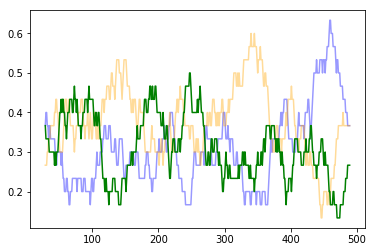

In [12]:
# TODO: break out the spare percentage between splits and non-split spares
#       because an increase in spare percentage could just come from leaving
#       less splits and/or from making more non-split spares and it would be
#       nice to know which
is_strike = (frames_df['T1'] == 10).astype(int)
rolling_strike = is_strike.rolling(30).mean()
is_open = (frames_df['T1'] + frames_df['T2'] < 10).astype(int)
rolling_open = is_open.rolling(30).mean()
rolling_spare = 1 - rolling_strike - rolling_open
rolling_strike.plot(color="blue", alpha=.4)
rolling_spare.plot(color="orange", alpha=.4)
rolling_open.plot(color="green");
# blue => strike
# orange => spare
# green => open

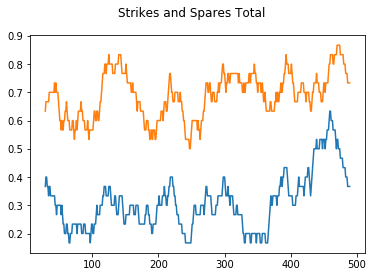

In [13]:
# this is the same data as the above plot, just stacked.
ax = pd.DataFrame({'Strike': rolling_strike, 'Spare': rolling_spare}).dropna().plot(
    stacked=True, legend=False)
ax.figure.suptitle('Strikes and Spares Total');

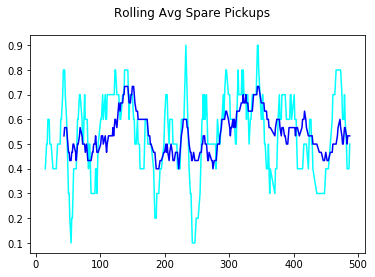

In [14]:
spare_leaves = frames_df[frames_df['T1'] < 10]
spare_pickups = (spare_leaves['T1'] + spare_leaves['T2'] == 10).astype(int)
ax = spare_pickups.rolling(10).mean().plot(color="cyan");
spare_pickups.rolling(30).mean().plot(color="blue")
ax.figure.suptitle('Rolling Avg Spare Pickups');

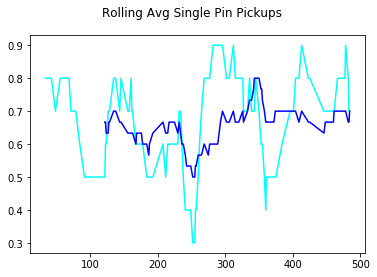

In [15]:
single_pin_leaves = frames_df[frames_df['T1'] == 9]
single_pin_spares = (single_pin_leaves['T2'] == 1).astype(int)
ax = single_pin_spares.rolling(10).mean().plot(color="cyan");
single_pin_spares.rolling(30).mean().plot(color="blue")
ax.figure.suptitle('Rolling Avg Single Pin Pickups');

In [16]:
def get_single_pin_leaves(pin_leaves, pin):
    for i, leave in enumerate(pin_leaves):
        if leave['first_ball'] == {pin}:
            yield i, leave

def get_makes(pin_leaves, pin):
    for i, leave in get_single_pin_leaves(pin_leaves, pin):
        if len(leave['second_ball']) == 0:
            yield i
            
def get_misses(pin_leaves, pin):
    for i, leave in get_single_pin_leaves(pin_leaves, pin):
        if len(leave['second_ball']) == 1:
            yield i

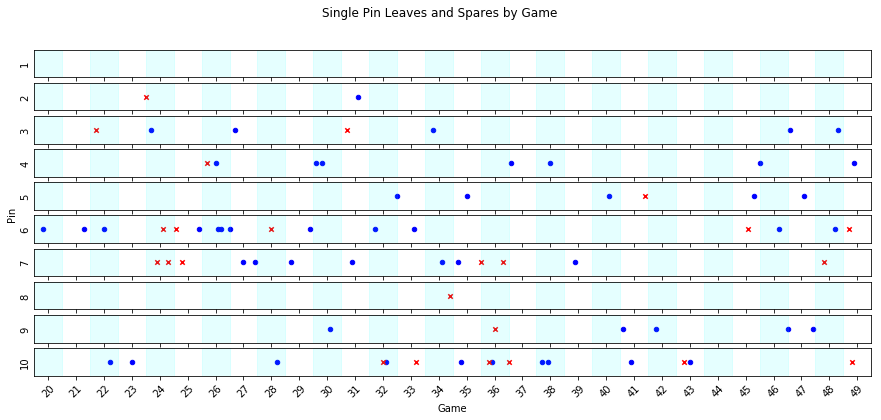

In [17]:
def plot_single_pin_leaves(pin_leaves, n_games=30):
    n_frames = n_games * 10
    end_frame = len(pin_leaves)
    start_frame = end_frame - n_frames
    pin_leaves = pin_leaves[-n_frames:]
    #x = range(len(pin_leaves))
    fig, axs = plt.subplots(nrows=10, ncols=1, sharex=True, figsize=(15, 6))
    for pin, ax in enumerate(axs, 1):
        makes = list(get_makes(pin_leaves, pin))
        ax.scatter(makes, [0]*len(makes), marker='o', color='b', s=20)
        misses = list(get_misses(pin_leaves, pin))
        ax.scatter(misses, [0]*len(misses), marker='x', color='r', s=20)
        ax.set_yticks([])
        ax.set_ylabel(pin)
        ax.set_xlim(0, n_frames)
        # color every other game
        for i in range(0, n_frames, 20):
            ax.axvspan(i, i+10, color='cyan', alpha=.1)
    # put a tick mark in the middle
    ax.set_xticks(range(5, n_frames+15, 10))
    ax.set_xticklabels(frames_to_games(start_frame, end_frame));
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    ax.set_xlim(0, n_frames)
    ax.set_xlabel('Game')
    fig.text(0.1, 0.5, 'Pin', va='center', rotation='vertical')
    fig.suptitle('Single Pin Leaves and Spares by Game');
    
def frames_to_games(start_frame, end_frame):
    return range(start_frame // 10 + 1, end_frame // 10 + 1)

    
plot_single_pin_leaves(pin_leaves)

In [18]:
rows = conn.execute('select Game, Frame, T1, T2 from T_Games').fetchall()

In [19]:
def score(a, b, c):
    if a['T1'] == 10:
        if b['T1'] == 10:
            assert a['Game'] == b['Game'] == c['Game']
            return 10 + 10 + c['T1']
        else:
            assert a['Game'] == b['Game']
            return 10 + b['T1'] + b['T2']
    elif a['T1'] + a['T2'] == 10:
        assert a['Game'] == b['Game']
        return 10 + b['T1']
    else:
        return a['T1'] + a['T2']

In [20]:
import itertools

In [21]:
frames = [[] for _ in range(10)]
for a, b, c in itertools.zip_longest(rows, rows[1:], rows[2:]):
    if a['Frame'] > 10:
        continue
    frames[a['Frame'] - 1].append(score(a, b, c))

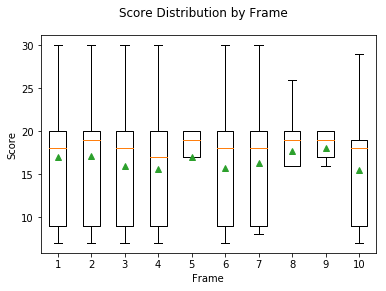

In [22]:
plt.boxplot(frames, sym='', showmeans=True);
plt.suptitle('Score Distribution by Frame');
plt.xlabel('Frame')
plt.ylabel('Score');

In [23]:
import numpy as np

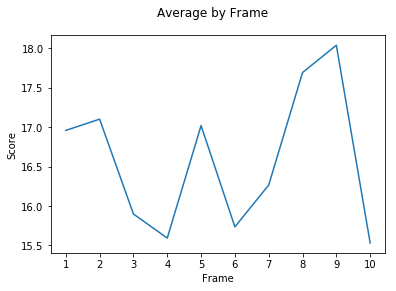

In [24]:
plt.plot(np.mean(frames, axis=1))
plt.xticks(range(10), labels=range(1, 11));
plt.xlabel('Frame')
plt.suptitle('Average by Frame');
plt.ylabel('Score');

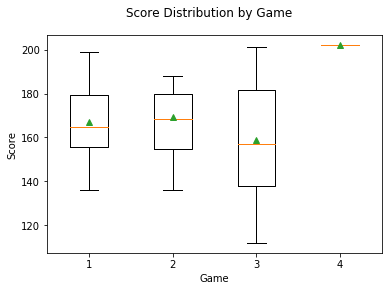

In [25]:
score_by_game = collections.defaultdict(list)
rows = conn.execute('select * from T_Score').fetchall()
for row in rows:
    score_by_game[row['Game']-1].append(row['Score'])
scores = [score_by_game[k] for k in sorted(score_by_game.keys())]
plt.boxplot(scores, sym='', showmeans=True);
plt.suptitle('Score Distribution by Game')
plt.xlabel('Game');
plt.ylabel('Score');